In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import OneClassSVM

%matplotlib inline

In [2]:
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label"
]

df = pd.read_csv("datasets/kddcup.data.corrected",
                 sep=",",
                 names=columns,
                 index_col=None)

In [3]:
df.shape

(4898431, 42)

In [4]:
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)
columns.remove("service")

novelties = df[df["label"] != "normal."]
novelties_normal = df[150000:154045]

novelties = pd.concat([novelties, novelties_normal])
normal = df[df["label"] == "normal."]

In [5]:
print(novelties.shape)
print(normal.shape)

(8090, 41)
(619046, 41)


In [6]:
novelties.head(5)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
226685,0,tcp,S0,0,0,0,0,0,0,0,...,1,0.00,0.31,0.53,0.00,0.01,1.00,0.52,0.00,portsweep.
226686,0,tcp,S0,0,0,0,0,0,0,0,...,2,0.01,0.31,0.53,0.00,0.02,1.00,0.52,0.00,portsweep.
226687,1,tcp,RSTOS0,1,0,0,0,0,0,0,...,3,0.01,0.31,0.53,0.00,0.02,0.67,0.52,0.33,portsweep.
263531,0,tcp,REJ,0,0,0,0,0,0,0,...,194,0.02,1.00,0.02,0.04,0.00,0.00,0.93,0.01,ipsweep.
263734,0,tcp,REJ,0,0,0,0,0,0,0,...,2,0.02,1.00,0.02,1.00,0.00,0.00,0.92,1.00,ipsweep.


In [7]:
novelties.tail(5)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
209742,0,tcp,SF,216,2431,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,normal.
209743,0,tcp,SF,218,8746,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,normal.
209744,0,tcp,SF,144,9534,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,normal.
209745,0,tcp,SF,244,250,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,normal.
209746,0,tcp,SF,205,12625,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,normal.


In [8]:
for col in normal.columns:
    if normal[col].dtype == "object":
        encoded = LabelEncoder()
        encoded.fit(normal[col])
        normal[col] = encoded.transform(normal[col])

for col in novelties.columns:
    if novelties[col].dtype == "object":
        encoded2 = LabelEncoder()
        encoded2.fit(novelties[col])
        novelties[col] = encoded2.transform(novelties[col])

<ipython-input-8-066313bbc580>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal[col] = encoded.transform(normal[col])


In [9]:
novelties.head(5)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
226685,0,0,3,0,0,0,0,0,0,0,...,1,0.00,0.31,0.53,0.00,0.01,1.00,0.52,0.00,6
226686,0,0,3,0,0,0,0,0,0,0,...,2,0.01,0.31,0.53,0.00,0.02,1.00,0.52,0.00,6
226687,1,0,1,1,0,0,0,0,0,0,...,3,0.01,0.31,0.53,0.00,0.02,0.67,0.52,0.33,6
263531,0,0,0,0,0,0,0,0,0,0,...,194,0.02,1.00,0.02,0.04,0.00,0.00,0.93,0.01,1
263734,0,0,0,0,0,0,0,0,0,0,...,2,0.02,1.00,0.02,1.00,0.00,0.00,0.92,1.00,1


In [10]:
novelties.tail(5)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
209742,0,0,6,216,2431,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,4
209743,0,0,6,218,8746,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,4
209744,0,0,6,144,9534,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,4
209745,0,0,6,244,250,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,4
209746,0,0,6,205,12625,0,0,0,0,0,...,255,1.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,4


In [11]:
for f in range(0, 10):
    normal = normal.iloc[np.random.permutation(len(normal))]

df2 = pd.concat([normal[:100000], normal[200000:250000]])
df_validate = normal[100000:150000]
x_train, x_test = train_test_split(df2, test_size=0.2, random_state=42)
x_val = df_validate

In [12]:
print("Shapes:\nx_train:{}\n".format(x_train.shape))
print("x_test:{}\n".format(x_test.shape))
print("x_val:{}\n".format(x_val.shape))

Shapes:
x_train:(120000, 41)

x_test:(30000, 41)

x_val:(50000, 41)



In [13]:
ocsvm = OneClassSVM(kernel='rbf', gamma=0.00005, nu=0.1)

In [14]:
ocsvm.fit(x_train)

OneClassSVM(gamma=5e-05, nu=0.1)

In [15]:
x_test['label'].value_counts()

0    30000
Name: label, dtype: int64

In [16]:
preds = ocsvm.predict(x_test)
score = 0
for f in range(0, x_test.shape[0]):
    if (preds[f] == 1):
        score = score + 1

accuracy = score / x_test.shape[0]
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 89.61%


In [17]:
preds = ocsvm.predict(x_val)
score = 0
for f in range(0, x_val.shape[0]):
    if (preds[f] == 1):
        score = score + 1

accuracy = score / x_val.shape[0]
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 89.39%


In [18]:
from sklearn.metrics import roc_auc_score

preds = ocsvm.predict(novelties)
matches = novelties["label"] == 4

auc = roc_auc_score(preds, matches)
print("AUC: {:.2%}".format(auc))

AUC: 95.83%


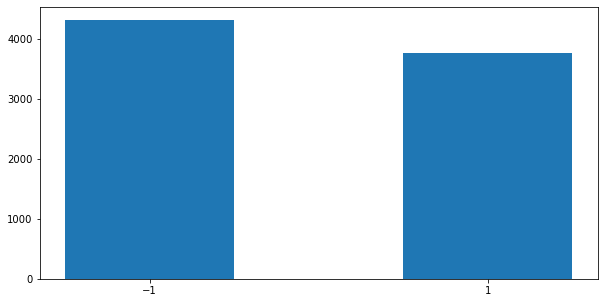

In [19]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=[-1.5, -0.5] + [0.5, 1.5], align='mid')
plt.xticks([-1, 1])
plt.show()